# MIDAS Heart/Resp Motion Pipeline

This notebook separates respiratory and cardiac motion, detects beats, and builds
time-series features for grouping into four conditions (control, doxo, doxo+epa, other).


## 0) Setup

We use the video frame rate as the sampling rate for time-series analysis.
At 60 fps, each beat has only ~3-4 samples for a 270-310 bpm heart rate.
This limits beat-shape fidelity and makes morphology comparisons unreliable.

Respiration is controlled; set RESP_CPM_RANGE to lock a narrow resp band.


## Saved figures
All plots are saved to `../outputs/figures/` as PNGs for later review.


## Sampling limitations limitations

At 60 fps and 270-310 bpm, each beat has ~11-13 samples.
This is better for beat-shape clustering, but morphology detail is still moderate.
We keep those sections for reference, but record-level features remain stable, and beat-level shape is more feasible at 60 fps.


In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment
from scipy.signal import butter, sosfiltfilt, welch, find_peaks, hilbert, detrend, firwin, filtfilt, iirnotch
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

try:
    from sktime.transformations.panel.rocket import MiniRocket
except Exception:
    MiniRocket = None

try:
    import hdbscan
except Exception:
    hdbscan = None

try:
    from umap import UMAP
except Exception:
    UMAP = None

try:
    from tslearn.clustering import KShape
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance
except Exception:
    KShape = None
    TimeSeriesScalerMeanVariance = None


/Users/taddeusbuica/Desktop/experiments/heart-ts-analysis/.venv/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
DATA_DIR = Path("../data")
FIG_DIR = Path("../outputs/figures")
FIG_DPI = 150
FRAME_RATE_FPS = 60.0
USE_FRAME_RATE = True
RESP_CPM_RANGE = (70.0, 80.0)
RESP_BAND_HZ = (1.0, 1.5)
RESP_PLOT_BAND_HZ = (0.6, 1.6)
RESP_MODEL = "sine"  # "sine" or "bandpass"
RESP_FIXED_CPM = 72.0
RESP_HARMONICS = 2
USE_FIR = True
RESP_FIR_TAPS = 801
HEART_FIR_TAPS = 401
HEART_NOTCH_RESP = True
HEART_NOTCH_Q = 30.0
HEART_NOTCH_HARMONICS = 2
HEART_ENV_NORMALIZE = True
HEART_ENV_SMOOTH_S = 0.2
RESP_MODEL = "sine"  # "sine" or "bandpass"
RESP_FIXED_CPM = 72.0
RESP_HARMONICS = 2
RESP_FILTER_ORDER = 6
HEART_FILTER_ORDER = 6
RESP_SEPARATION_BAND_HZ = None
RESP_DECOMP_CUTOFF_HZ = 2.0
MIN_BPM = 270
MAX_BPM = 310
HEART_BAND_HZ = (MIN_BPM / 60.0, MAX_BPM / 60.0)
HEART_BAND_WIDE_HZ = (4.0, 6.5)
HEART_SEPARATION_BAND_HZ = HEART_BAND_WIDE_HZ
HEART_DECOMP_BAND_HZ = HEART_BAND_HZ
HEART_DETECT_BAND_HZ = HEART_BAND_HZ
RESP_REMOVE_HEART = True
HEART_USE_RESP_RESIDUAL = True
HEART_DETECT_USE_RESIDUAL = True
HEART_DETECT_METHOD = "filter"
SEPARATION_METHOD = "filter"
DECOMPOSITION_METHOD = "fft"
DECOMPOSITION_OUTPUT_TAG = "filter"
RESP_CYCLES_OUTPUT_TAG = "filter"
REFRACTORY_S = 0.85 * (60.0 / MAX_BPM)
BEAT_WINDOW_S = (0.3 * (60.0 / MIN_BPM), 0.7 * (60.0 / MIN_BPM))
ENV_SMOOTH_S = 0.02
BEAT_PROMINENCE = 0.8
RESP_MIN_PERIOD_S = 0.5
RESP_SMOOTH_S = 0.05
RESP_PROMINENCE_FACTOR = 0.35
RESP_PLOT_TRIM_S = 1.0
ZOOM_START_S = 10.0
ZOOM_DURATION_S = 10.0
RESAMPLE_LEN = 256
MAX_BEATS_PER_RECORD = 60
BEAT_SAMPLE_SEED = 0
BEATS_PER_SEGMENTS = (5, 10)
SEGMENT_STRIDE = 1
SEGMENT_BEAT_PROMINENCE = 0.1

def fft_isolate_band(signal: np.ndarray, fs: float, low_bpm: float, high_bpm: float) -> np.ndarray:
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    fft_vals = np.fft.rfft(signal)
    mask = (freqs >= low_bpm/60.0) & (freqs <= high_bpm/60.0)
    filtered_fft = np.zeros_like(fft_vals)
    filtered_fft[mask] = fft_vals[mask]
    return np.fft.irfft(filtered_fft, n=n)


In [3]:
def save_fig(name: str, out_dir: Path | None = None) -> None:
    target_dir = FIG_DIR if out_dir is None else out_dir
    target_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(target_dir / name, dpi=FIG_DPI, bbox_inches="tight")


In [4]:
def resp_band_from_target() -> tuple[float, float]:
    if RESP_SEPARATION_BAND_HZ is not None:
        return RESP_SEPARATION_BAND_HZ
    if RESP_CPM_RANGE is None:
        return RESP_BAND_HZ
    low_bpm, high_bpm = RESP_CPM_RANGE
    return (max(0.01, low_bpm / 60.0), high_bpm / 60.0)


def resp_band_for_cycles() -> tuple[float, float]:
    if RESP_CPM_RANGE is None:
        return resp_band_from_target()
    low_bpm, high_bpm = RESP_CPM_RANGE
    return (max(0.01, low_bpm / 60.0), high_bpm / 60.0)


## Expected heart rate range

Targeting 270-310 bpm (~4.5-5.2 Hz). We set a tight heart band and
derive refractory period and beat window sizes from this range.



## 1) Load data and estimate sampling rate

If `USE_FRAME_RATE` is enabled, the time column is ignored and time is reconstructed
from the constant frame rate. This avoids mislabeled or inconsistent timestamps.


In [5]:
@dataclass
class Record:
    path: Path
    label: str
    time_s: np.ndarray
    signal: np.ndarray
    fs: float
    group_id: str


def label_from_name(name: str) -> str:
    lower = name.lower()
    if lower.startswith("control"):
        return "control"
    if lower.startswith("empa_doxo") or lower.startswith("preconditionare_empa_doxo"):
        return "empa_doxo"
    if lower.startswith("doxo") or lower.startswith("doxo_re"):
        return "doxo"
    if lower.startswith("empa"):
        return "empa"
    return "other"


def load_records(data_dir: Path) -> list[Record]:
    records: list[Record] = []
    for path in sorted(data_dir.glob("*.csv")):
        df = pd.read_csv(path)
        signal = df.iloc[:, 1].to_numpy(dtype=float)
        if USE_FRAME_RATE:
            fs = FRAME_RATE_FPS
            time_s = np.arange(len(signal)) / fs
        else:
            time_s = df.iloc[:, 0].to_numpy(dtype=float)
            dt = np.diff(time_s)
            fs = 1.0 / float(np.median(dt)) if len(dt) else 0.0
        records.append(
            Record(
                path=path,
                label=label_from_name(path.stem),
                time_s=time_s,
                signal=signal,
                fs=fs,
                group_id=path.stem,
            )
        )
    return records


records = load_records(DATA_DIR)
{rec.path.name: rec.fs for rec in records}


{'control(I.1)_plot_data.csv': 60.0,
 'control(I.2)_plot_data.csv': 60.0,
 'control(I.3)_plot_data.csv': 60.0,
 'control(I.4)_plot_data.csv': 60.0,
 'doxo(IV.1)_2_plot_data.csv': 60.0,
 'doxo(IV.1)_plot_data.csv': 60.0,
 'doxo(IV.2)_plot_data.csv': 60.0,
 'doxo_re(IV.3)_plot_data.csv': 60.0,
 'doxo_re(IV.4)_plot_data.csv': 60.0,
 'empa(II.1)_plot_data.csv': 60.0,
 'empa(II.2)_plot_data.csv': 60.0,
 'empa(II.3)_plot_data.csv': 60.0,
 'empa_doxo(III.1)_plot_data.csv': 60.0,
 'empa_doxo(III.2)_plot_data.csv': 60.0,
 'empa_doxo(III.3)_plot_data.csv': 60.0,
 'preconditionare_empa_doxo(V.1)_plot_data.csv': 60.0,
 'preconditionare_empa_doxo(V.2)_plot_data.csv': 60.0,
 'preconditionare_empa_doxo(V.3)_plot_data.csv': 60.0}

## 2) Spectrum inspection (Welch PSD)

Use PSD to confirm the heart-band peak is present and separated from respiration.
At low sampling rates, the heart band sits near Nyquist and can be noisy.


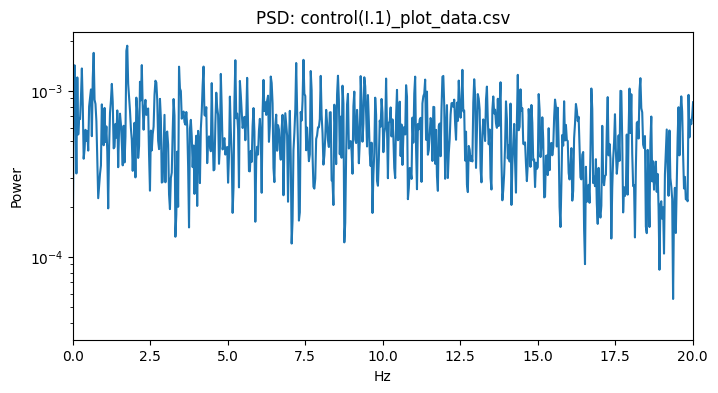

In [6]:
rec = records[0]
f, pxx = welch(rec.signal, fs=rec.fs, nperseg=min(2048, len(rec.signal)))
plt.figure(figsize=(8, 4))
plt.semilogy(f, pxx)
plt.title(f"PSD: {rec.path.name}")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.xlim(0, 20)
save_fig(f"psd_{rec.path.stem}.png")
plt.show()


## 2c) Rough HR estimation via PSD peak
At 60 fps, beat shapes are under-sampled, but the PSD peak can still provide
a rough heart-rate estimate. This uses frequency-domain energy only.


## 2b) Fourier decomposition (FFT masking)

FFT masking provides a quick split, but can introduce ringing and boundary artifacts.
Compare with filter-based separation if results look distorted.


## 3) Separate respiration and heart (zero-phase filtering)

Zero-phase filters reduce timing shifts, which is critical for beat detection.
With low fps, keep the band narrow and avoid aggressive filtering.


In [7]:
def band_limits(band: tuple[float, float], fs: float) -> tuple[float, float]:
    low, high = band
    nyq = fs / 2.0
    return (max(0.01, low), min(high, 0.95 * nyq))


def butter_sos(band: tuple[float, float], fs: float, order: int = 4) -> np.ndarray:
    low, high = band_limits(band, fs)
    return butter(order, [low, high], btype="bandpass", fs=fs, output="sos")


def lowpass_sos(cutoff: float, fs: float, order: int = 4) -> np.ndarray:
    cutoff = min(cutoff, 0.95 * (fs / 2.0))
    return butter(order, cutoff, btype="lowpass", fs=fs, output="sos")


def fir_bandpass(signal: np.ndarray, band: tuple[float, float], fs: float, taps: int) -> np.ndarray:
    low, high = band_limits(band, fs)
    taps = max(3, int(taps))
    if taps % 2 == 0:
        taps += 1
    coeffs = firwin(taps, [low, high], pass_zero=False, fs=fs)
    return filtfilt(coeffs, [1.0], signal)


def bandpass_filter(signal: np.ndarray, band: tuple[float, float], fs: float, order: int, taps: int, use_fir: bool) -> np.ndarray:
    if use_fir:
        return fir_bandpass(signal, band, fs, taps)
    sos = butter_sos(band, fs, order=order)
    return sosfiltfilt(sos, signal)


def apply_notches(signal: np.ndarray, fs: float, freqs: list[float], q: float) -> np.ndarray:
    filtered = signal
    nyq = fs / 2.0
    for freq in freqs:
        if freq <= 0 or freq >= nyq:
            continue
        b, a = iirnotch(freq, q, fs=fs)
        filtered = filtfilt(b, a, filtered)
    return filtered


def fft_bandpass(signal: np.ndarray, fs: float, band: tuple[float, float]) -> np.ndarray:
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1.0 / fs)
    fft_vals = np.fft.rfft(signal)
    low, high = band
    mask = (freqs >= low) & (freqs <= high)
    filtered_fft = np.where(mask, fft_vals, 0)
    return np.fft.irfft(filtered_fft, n=n)


def zoom_window(time_s: np.ndarray) -> tuple[float, float]:
    start = ZOOM_START_S
    end = ZOOM_START_S + ZOOM_DURATION_S
    if len(time_s) == 0:
        return (start, end)
    end = min(end, float(time_s[-1]))
    return (start, end)


def zoom_mask(time_s: np.ndarray) -> np.ndarray:
    start = ZOOM_START_S
    end = ZOOM_START_S + ZOOM_DURATION_S
    if len(time_s) == 0:
        return np.array([], dtype=bool)
    end = min(end, float(time_s[-1]))
    return (time_s >= start) & (time_s <= end)


def preprocess_signal(signal: np.ndarray) -> np.ndarray:
    return detrend(signal, type="linear")


def resp_target_hz() -> float:
    if RESP_FIXED_CPM is not None:
        return RESP_FIXED_CPM / 60.0
    if RESP_CPM_RANGE is not None:
        return (sum(RESP_CPM_RANGE) / 2.0) / 60.0
    return 1.2


def fit_resp_sinusoid(signal: np.ndarray, fs: float, harmonics: int = 1) -> np.ndarray:
    t = np.arange(len(signal)) / fs
    f0 = resp_target_hz()
    cols = [np.ones_like(t)]
    for h in range(1, harmonics + 1):
        omega = 2.0 * np.pi * f0 * h
        cols.append(np.sin(omega * t))
        cols.append(np.cos(omega * t))
    X = np.column_stack(cols)
    coef, *_ = np.linalg.lstsq(X, signal, rcond=None)
    return X @ coef


def extract_resp_component(signal: np.ndarray, fs: float, for_plot: bool) -> np.ndarray:
    signal = preprocess_signal(signal)
    if RESP_MODEL == "sine":
        return fit_resp_sinusoid(signal, fs, harmonics=RESP_HARMONICS)
    resp_band = RESP_PLOT_BAND_HZ if for_plot and RESP_PLOT_BAND_HZ is not None else resp_band_from_target()
    resp_source = signal
    if RESP_REMOVE_HEART:
        heart_for_sub = bandpass_filter(signal, HEART_DECOMP_BAND_HZ, fs, HEART_FILTER_ORDER, HEART_FIR_TAPS, USE_FIR)
        resp_source = signal - heart_for_sub
    return bandpass_filter(resp_source, resp_band, fs, RESP_FILTER_ORDER, RESP_FIR_TAPS, USE_FIR)


def separate_components(signal: np.ndarray, fs: float, method: str = "filter") -> tuple[np.ndarray, np.ndarray]:
    """
    Separates respiratory and heart components using band-limited filtering.
    Respiration is removed from the heart channel by default.
    """
    signal = preprocess_signal(signal)
    resp = extract_resp_component(signal, fs, for_plot=False)
    source = signal - resp if HEART_USE_RESP_RESIDUAL else signal
    if HEART_NOTCH_RESP:
        base = resp_target_hz()
        freqs = [base * h for h in range(1, HEART_NOTCH_HARMONICS + 1)]
        source = apply_notches(source, fs, freqs, HEART_NOTCH_Q)

    if method == "fft":
        heart = fft_bandpass(source, fs, HEART_SEPARATION_BAND_HZ)
        return resp, heart
    if method == "filter":
        heart = bandpass_filter(source, HEART_SEPARATION_BAND_HZ, fs, HEART_FILTER_ORDER, HEART_FIR_TAPS, USE_FIR)
        return resp, heart
    raise ValueError(f"Unknown separation method: {method}")


def decompose_for_plot(signal: np.ndarray, fs: float, method: str) -> tuple[np.ndarray, np.ndarray]:
    signal = preprocess_signal(signal)
    resp = extract_resp_component(signal, fs, for_plot=True)
    source = signal - resp
    if HEART_NOTCH_RESP:
        base = resp_target_hz()
        freqs = [base * h for h in range(1, HEART_NOTCH_HARMONICS + 1)]
        source = apply_notches(source, fs, freqs, HEART_NOTCH_Q)

    if method == "fft":
        heart = fft_bandpass(source, fs, HEART_DECOMP_BAND_HZ)
        return resp, heart

    heart = bandpass_filter(source, HEART_DECOMP_BAND_HZ, fs, HEART_FILTER_ORDER, HEART_FIR_TAPS, USE_FIR)
    return resp, heart


def extract_resp_for_cycles(signal: np.ndarray, fs: float) -> np.ndarray:
    return extract_resp_component(signal, fs, for_plot=False)


def extract_heart_for_beats(signal: np.ndarray, fs: float) -> np.ndarray:
    signal = preprocess_signal(signal)
    resp = extract_resp_component(signal, fs, for_plot=False)
    source = signal - resp if HEART_DETECT_USE_RESIDUAL else signal
    if HEART_NOTCH_RESP:
        base = resp_target_hz()
        freqs = [base * h for h in range(1, HEART_NOTCH_HARMONICS + 1)]
        source = apply_notches(source, fs, freqs, HEART_NOTCH_Q)

    heart = bandpass_filter(source, HEART_DETECT_BAND_HZ, fs, HEART_FILTER_ORDER, HEART_FIR_TAPS, USE_FIR)
    if HEART_ENV_NORMALIZE:
        env = np.abs(hilbert(heart))
        env = smooth_signal(env, fs, HEART_ENV_SMOOTH_S)
        heart = heart / (env + 1e-9)
    return heart


def smooth_signal(signal: np.ndarray, fs: float, window_s: float) -> np.ndarray:
    window = max(1, int(window_s * fs))
    if window <= 1:
        return signal
    kernel = np.ones(window) / window
    return np.convolve(signal, kernel, mode="same")


def detect_beats_for_segments(heart: np.ndarray, fs: float) -> np.ndarray:
    heart_norm = (heart - np.median(heart)) / (np.median(np.abs(heart - np.median(heart))) + 1e-9)
    min_dist = int(REFRACTORY_S * fs)
    peaks, _ = find_peaks(heart_norm, distance=min_dist, prominence=SEGMENT_BEAT_PROMINENCE)
    return peaks


def detect_beats(heart: np.ndarray, fs: float) -> tuple[np.ndarray, np.ndarray]:
    heart_norm = (heart - np.median(heart)) / (np.median(np.abs(heart - np.median(heart))) + 1e-9)

    min_dist = int(REFRACTORY_S * fs)
    peaks, _ = find_peaks(heart_norm, distance=min_dist, prominence=BEAT_PROMINENCE)
    return peaks, heart_norm


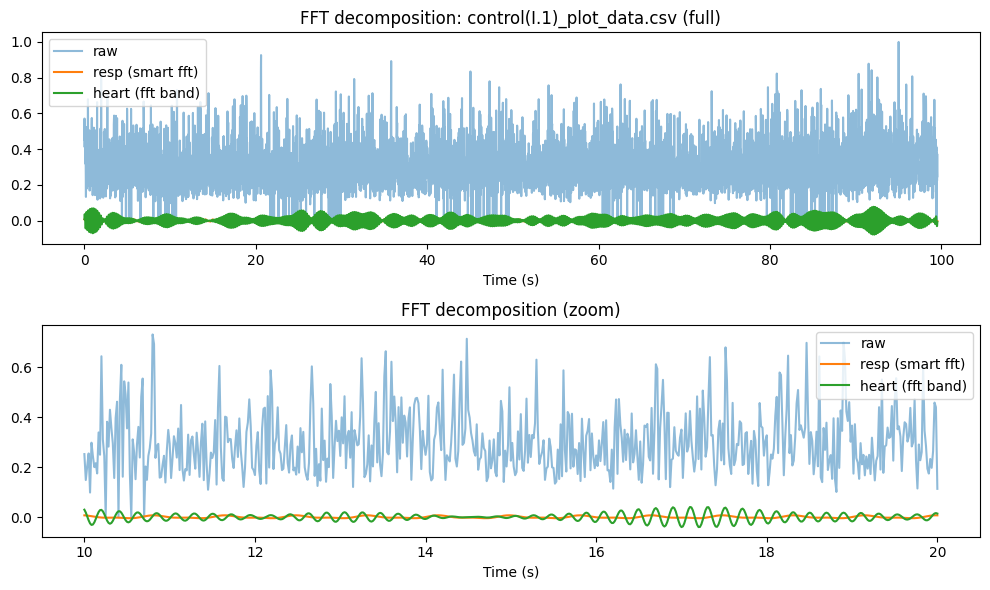

In [8]:
rec = records[0]
resp_fft, heart_fft = decompose_for_plot(rec.signal, rec.fs, method="fft")

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
axes[0].plot(rec.time_s, rec.signal, label="raw", alpha=0.5)
axes[0].plot(rec.time_s, resp_fft, label="resp (smart fft)")
axes[0].plot(rec.time_s, heart_fft, label="heart (fft band)")
axes[0].legend()
axes[0].set_title(f"FFT decomposition: {rec.path.name} (full)")
axes[0].set_xlabel("Time (s)")

mask = zoom_mask(rec.time_s)
axes[1].plot(rec.time_s[mask], rec.signal[mask], label="raw", alpha=0.5)
axes[1].plot(rec.time_s[mask], resp_fft[mask], label="resp (smart fft)")
axes[1].plot(rec.time_s[mask], heart_fft[mask], label="heart (fft band)")
axes[1].legend()
axes[1].set_title("FFT decomposition (zoom)")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
save_fig(f"fft_decomposition_{rec.path.stem}.png")
plt.show()


In [9]:
def estimate_hr_psd(signal: np.ndarray, fs: float, band: tuple[float, float], method: str) -> float | None:
    heart = extract_heart_for_beats(signal, fs)
    f, pxx = welch(heart, fs=fs, nperseg=min(2048, len(heart)))
    low, high = band
    mask = (f >= low) & (f <= high)
    if not np.any(mask):
        return None
    idx = np.argmax(pxx[mask])
    peak_hz = f[mask][idx]
    return 60.0 * peak_hz


hr_psd = []
for rec in records:
    hr = estimate_hr_psd(rec.signal, rec.fs, HEART_BAND_HZ, SEPARATION_METHOD)
    hr_psd.append(hr)

print("PSD HR (bpm):", [round(h, 1) if h else None for h in hr_psd])
if any(h is not None for h in hr_psd):
    arr = np.array([h for h in hr_psd if h is not None])
    print(f"PSD HR summary: mean={arr.mean():.1f}, median={np.median(arr):.1f}, min={arr.min():.1f}, max={arr.max():.1f}")


PSD HR (bpm): [286.5, 291.8, 288.3, 279.5, 286.5, 297.1, 297.1, 286.5, 297.1, 298.8, 295.3, 302.3, 286.5, 295.3, 297.1, 283.0, 284.8, 295.3]
PSD HR summary: mean=291.6, median=293.6, min=279.5, max=302.3


## 3b) Decomposition plots by category

We plot one representative file per category to compare component separation.
If components look similar across categories, clustering will be difficult.


## 3c) Respiratory cycle timing (full cycle + inhale/exhale)
We estimate respiration cycle durations from the low-frequency component.
At 60 fps this is reliable because respiration is slow and periodic.


In [10]:
def smooth_signal(signal: np.ndarray, fs: float, window_s: float) -> np.ndarray:
    window = max(1, int(window_s * fs))
    if window <= 1:
        return signal
    kernel = np.ones(window) / window
    return np.convolve(signal, kernel, mode="same")


def analyze_resp_cycles(resp: np.ndarray, fs: float) -> dict:
    resp_smoothed = smooth_signal(resp, fs, RESP_SMOOTH_S)
    resp_min_period_s = RESP_MIN_PERIOD_S
    if RESP_CPM_RANGE is not None:
        resp_min_period_s = 0.7 * (60.0 / max(RESP_CPM_RANGE))
    distance = max(1, int(resp_min_period_s * fs))
    median = np.median(resp_smoothed)
    mad = np.median(np.abs(resp_smoothed - median)) + 1e-9
    prominence = mad * RESP_PROMINENCE_FACTOR

    peaks, _ = find_peaks(resp_smoothed, distance=distance, prominence=prominence)
    troughs, _ = find_peaks(-resp_smoothed, distance=distance, prominence=prominence)

    peaks_t = peaks / fs
    troughs_t = troughs / fs

    full_cycles = np.diff(peaks_t).tolist() if len(peaks_t) > 1 else []
    inhalations = []
    exhalations = []

    for peak_t in peaks_t:
        prev_troughs = troughs_t[troughs_t < peak_t]
        next_troughs = troughs_t[troughs_t > peak_t]
        if len(prev_troughs) > 0:
            inhalations.append(float(peak_t - prev_troughs[-1]))
        if len(next_troughs) > 0:
            exhalations.append(float(next_troughs[0] - peak_t))

    return {
        "resp_smoothed": resp_smoothed,
        "peaks": peaks,
        "troughs": troughs,
        "full_cycle_s": full_cycles,
        "inhalation_s": inhalations,
        "exhalation_s": exhalations,
    }


for rec in records:
    resp, _ = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
    metrics = analyze_resp_cycles(resp, rec.fs)
    full_cycle = metrics["full_cycle_s"]
    inhale = metrics["inhalation_s"]
    exhale = metrics["exhalation_s"]
    if full_cycle:
        print(f"{rec.path.name} full cycle: mean={np.mean(full_cycle):.2f}s, median={np.median(full_cycle):.2f}s")
        if RESP_CPM_RANGE is not None:
            expected_period = 60.0 / (sum(RESP_CPM_RANGE) / 2.0)
            delta = np.mean(full_cycle) - expected_period
            print(f"{rec.path.name} cycle delta vs expected: {delta:+.2f}s")
    if inhale:
        print(f"{rec.path.name} inhalation: mean={np.mean(inhale):.2f}s, median={np.median(inhale):.2f}s")
    if exhale:
        print(f"{rec.path.name} exhalation: mean={np.mean(exhale):.2f}s, median={np.median(exhale):.2f}s")



control(I.1)_plot_data.csv full cycle: mean=0.83s, median=0.83s
control(I.1)_plot_data.csv cycle delta vs expected: +0.03s
control(I.1)_plot_data.csv inhalation: mean=0.28s, median=0.28s
control(I.1)_plot_data.csv exhalation: mean=0.55s, median=0.55s
control(I.2)_plot_data.csv full cycle: mean=0.83s, median=0.83s
control(I.2)_plot_data.csv cycle delta vs expected: +0.03s
control(I.2)_plot_data.csv inhalation: mean=0.62s, median=0.62s
control(I.2)_plot_data.csv exhalation: mean=0.22s, median=0.22s
control(I.3)_plot_data.csv full cycle: mean=0.83s, median=0.83s
control(I.3)_plot_data.csv cycle delta vs expected: +0.03s
control(I.3)_plot_data.csv inhalation: mean=0.53s, median=0.53s
control(I.3)_plot_data.csv exhalation: mean=0.30s, median=0.30s
control(I.4)_plot_data.csv full cycle: mean=0.83s, median=0.83s
control(I.4)_plot_data.csv cycle delta vs expected: +0.03s
control(I.4)_plot_data.csv inhalation: mean=0.23s, median=0.23s
control(I.4)_plot_data.csv exhalation: mean=0.60s, median=0.

empa_doxo(III.3)_plot_data.csv full cycle: mean=0.83s, median=0.83s
empa_doxo(III.3)_plot_data.csv cycle delta vs expected: +0.03s
empa_doxo(III.3)_plot_data.csv inhalation: mean=0.62s, median=0.62s
empa_doxo(III.3)_plot_data.csv exhalation: mean=0.22s, median=0.22s
preconditionare_empa_doxo(V.1)_plot_data.csv full cycle: mean=0.83s, median=0.83s
preconditionare_empa_doxo(V.1)_plot_data.csv cycle delta vs expected: +0.03s
preconditionare_empa_doxo(V.1)_plot_data.csv inhalation: mean=0.23s, median=0.23s
preconditionare_empa_doxo(V.1)_plot_data.csv exhalation: mean=0.60s, median=0.60s
preconditionare_empa_doxo(V.2)_plot_data.csv full cycle: mean=0.83s, median=0.83s
preconditionare_empa_doxo(V.2)_plot_data.csv cycle delta vs expected: +0.03s
preconditionare_empa_doxo(V.2)_plot_data.csv inhalation: mean=0.56s, median=0.57s
preconditionare_empa_doxo(V.2)_plot_data.csv exhalation: mean=0.27s, median=0.27s
preconditionare_empa_doxo(V.3)_plot_data.csv full cycle: mean=0.83s, median=0.83s
preco

## 3d) Respiratory cycle visualization by category
Plots the smoothed respiratory signal with detected peaks and troughs.


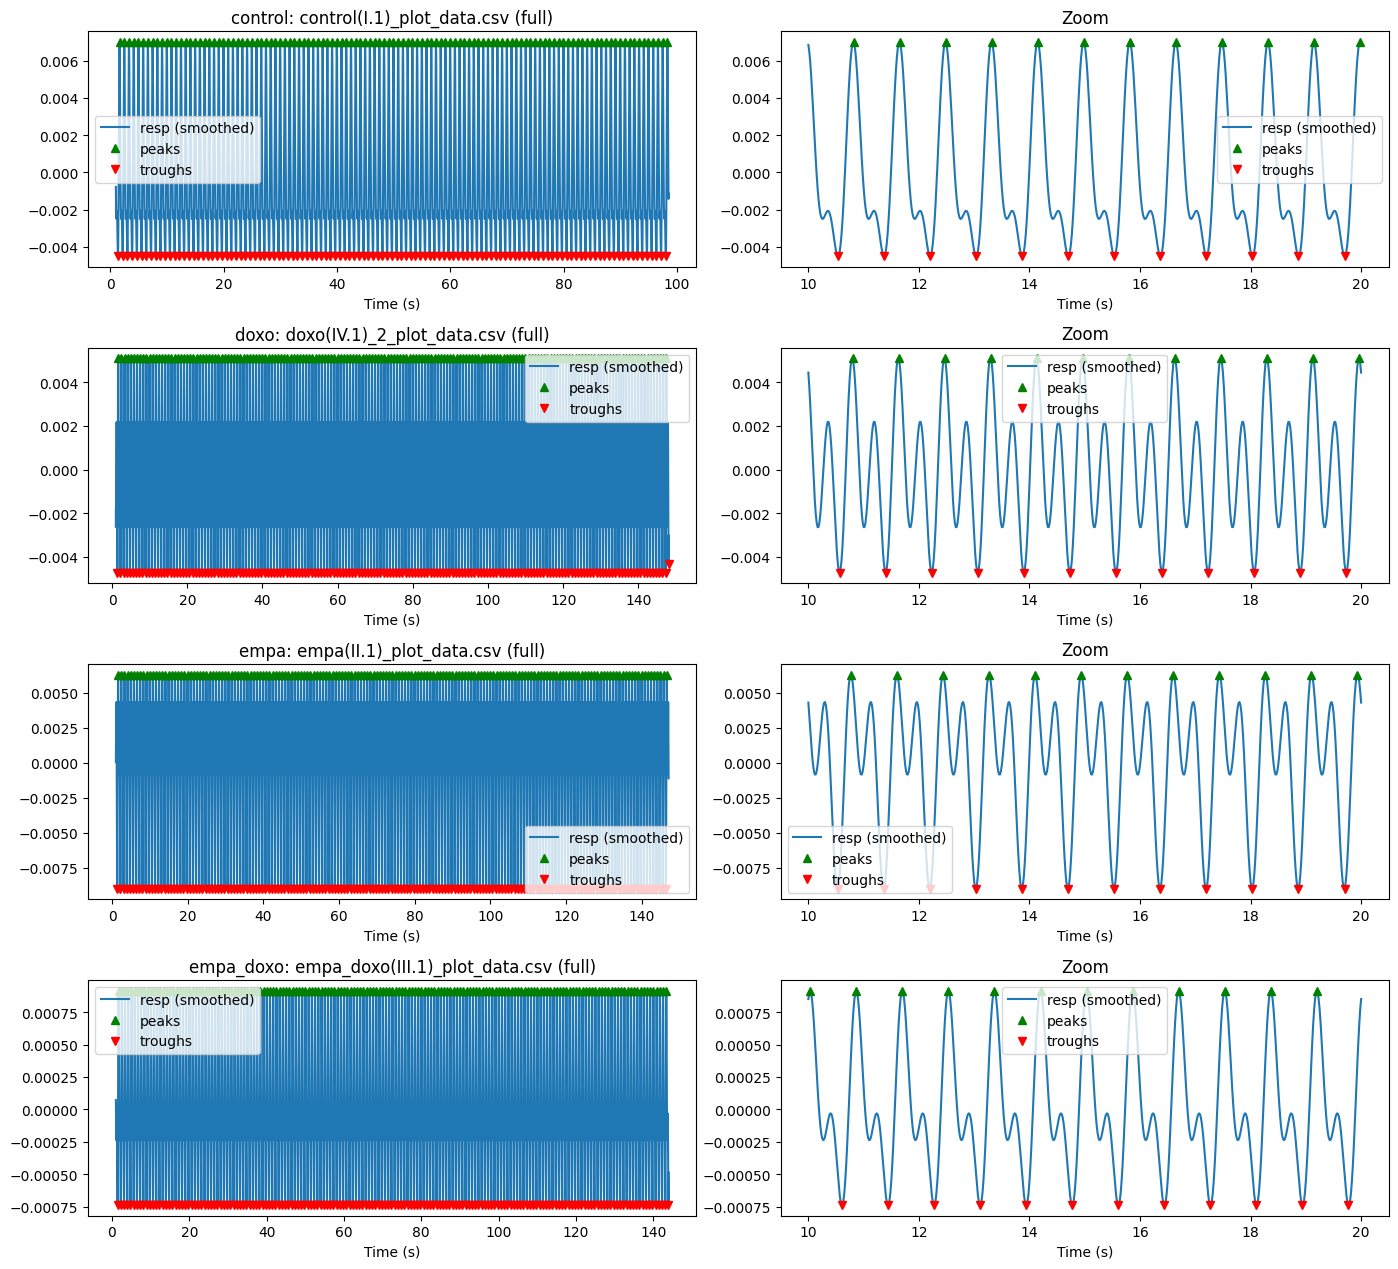

In [11]:
def plot_resp_cycles_by_category(records: list[Record], method: str, output_tag: str) -> None:
    grouped: dict[str, list[Record]] = {}
    for rec in records:
        grouped.setdefault(rec.label, []).append(rec)

    labels = sorted(grouped.keys())
    fig, axes = plt.subplots(len(labels), 2, figsize=(14, 3.2 * len(labels)))
    if len(labels) == 1:
        axes = [axes]

    for row, label in enumerate(labels):
        rec = grouped[label][0]
        resp_full = extract_resp_for_cycles(rec.signal, rec.fs)
        trim = int(RESP_PLOT_TRIM_S * rec.fs)
        if trim * 2 < len(resp_full):
            resp = resp_full[trim:-trim]
            time_s = rec.time_s[trim:-trim]
        else:
            resp = resp_full
            time_s = rec.time_s
        metrics = analyze_resp_cycles(resp, rec.fs)
        resp_smoothed = metrics["resp_smoothed"]
        full_ax = axes[row][0]
        zoom_ax = axes[row][1]
        full_ax.plot(time_s, resp_smoothed, label="resp (smoothed)")
        full_ax.plot(time_s[metrics["peaks"]], resp_smoothed[metrics["peaks"]], "g^", label="peaks")
        full_ax.plot(time_s[metrics["troughs"]], resp_smoothed[metrics["troughs"]], "rv", label="troughs")
        full_ax.set_title(f"{label}: {rec.path.name} (full)")
        full_ax.set_xlabel("Time (s)")
        full_ax.legend()

        mask = zoom_mask(time_s)
        start, end = zoom_window(time_s)
        peaks_zoom = metrics["peaks"][(time_s[metrics["peaks"]] >= start) & (time_s[metrics["peaks"]] <= end)]
        troughs_zoom = metrics["troughs"][(time_s[metrics["troughs"]] >= start) & (time_s[metrics["troughs"]] <= end)]
        zoom_ax.plot(time_s[mask], resp_smoothed[mask], label="resp (smoothed)")
        zoom_ax.plot(time_s[peaks_zoom], resp_smoothed[peaks_zoom], "g^", label="peaks")
        zoom_ax.plot(time_s[troughs_zoom], resp_smoothed[troughs_zoom], "rv", label="troughs")
        zoom_ax.set_title("Zoom")
        zoom_ax.set_xlabel("Time (s)")
        zoom_ax.legend()

    plt.tight_layout()
    save_fig(f"resp_cycles_by_category_{output_tag}.png")
    plt.show()


plot_resp_cycles_by_category(records, DECOMPOSITION_METHOD, RESP_CYCLES_OUTPUT_TAG)


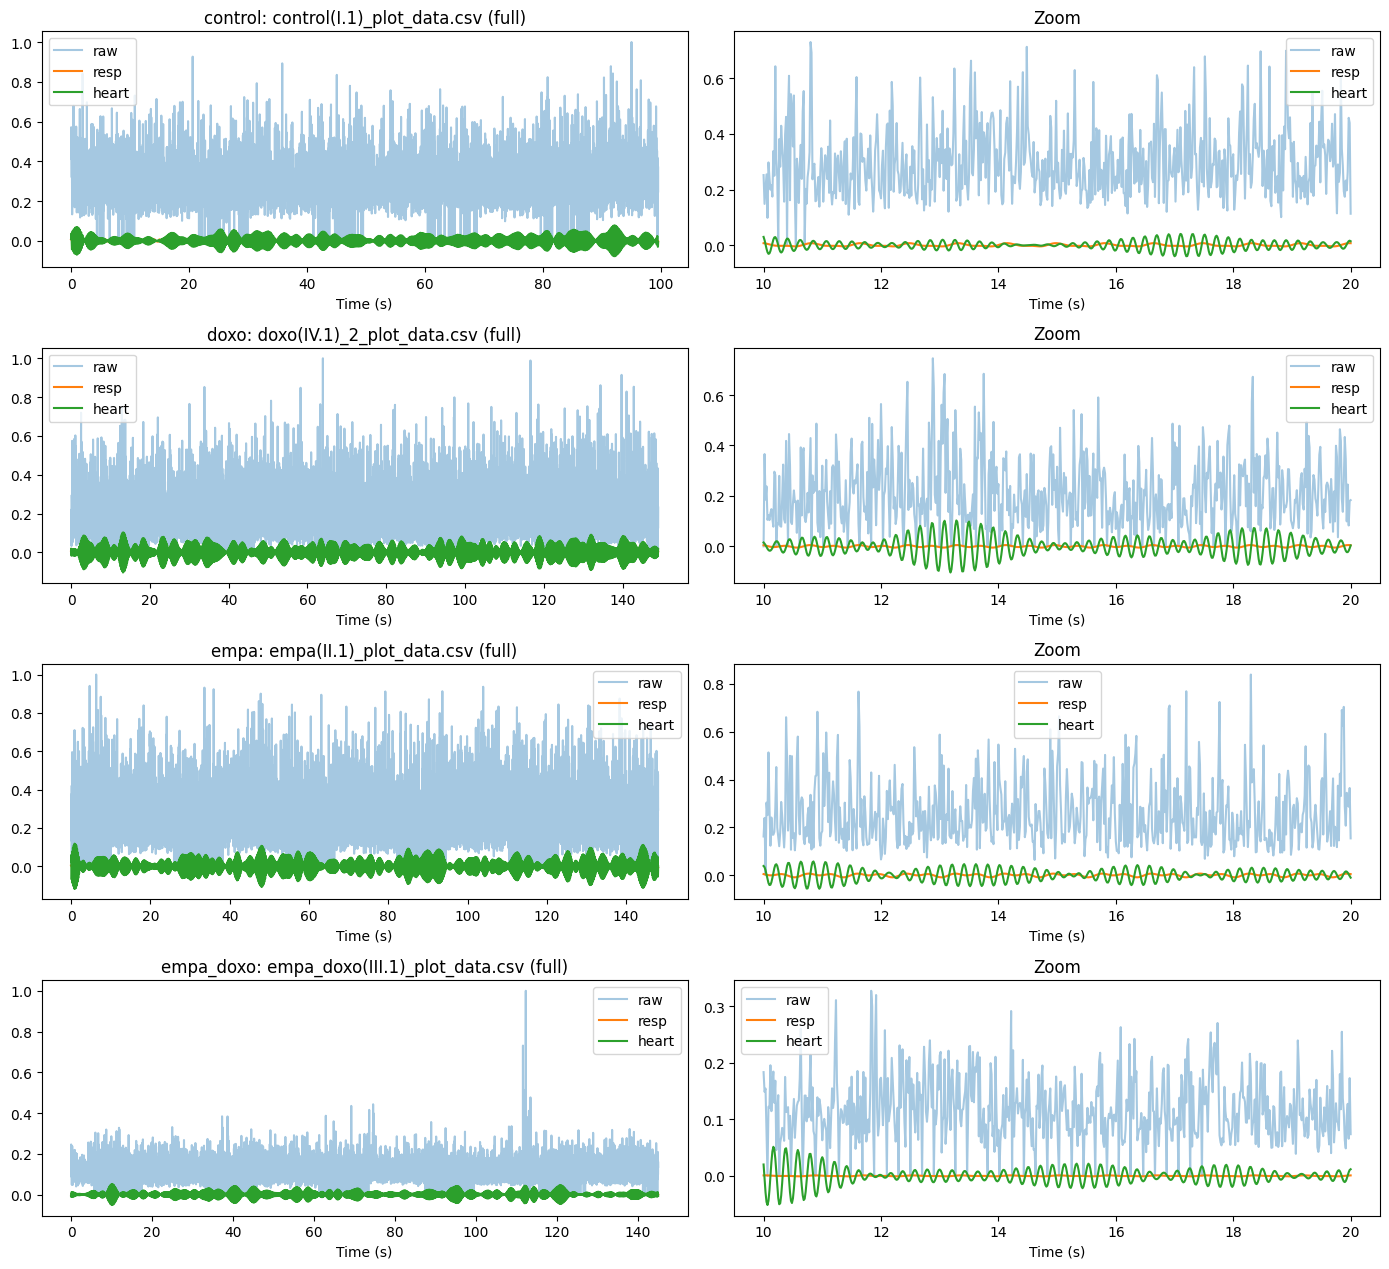

In [12]:
def plot_category_decomposition(records: list[Record], method: str, output_tag: str) -> None:
    grouped: dict[str, list[Record]] = {}
    for rec in records:
        grouped.setdefault(rec.label, []).append(rec)

    labels = sorted(grouped.keys())
    fig, axes = plt.subplots(len(labels), 2, figsize=(14, 3.2 * len(labels)))
    if len(labels) == 1:
        axes = [axes]

    for row, label in enumerate(labels):
        rec = grouped[label][0]
        resp, heart = decompose_for_plot(rec.signal, rec.fs, method=method)
        full_ax = axes[row][0]
        zoom_ax = axes[row][1]
        full_ax.plot(rec.time_s, rec.signal, label="raw", alpha=0.4)
        full_ax.plot(rec.time_s, resp, label="resp")
        full_ax.plot(rec.time_s, heart, label="heart")
        full_ax.set_title(f"{label}: {rec.path.name} (full)")
        full_ax.set_xlabel("Time (s)")
        full_ax.legend()

        mask = zoom_mask(rec.time_s)
        zoom_ax.plot(rec.time_s[mask], rec.signal[mask], label="raw", alpha=0.4)
        zoom_ax.plot(rec.time_s[mask], resp[mask], label="resp")
        zoom_ax.plot(rec.time_s[mask], heart[mask], label="heart")
        zoom_ax.set_title("Zoom")
        zoom_ax.set_xlabel("Time (s)")
        zoom_ax.legend()

    plt.tight_layout()
    save_fig(f"decomposition_by_category_{output_tag}.png")
plt.show()


plot_category_decomposition(records, DECOMPOSITION_METHOD, DECOMPOSITION_OUTPUT_TAG)


## 4) Beat detection on heart component

Beat picking uses the heart-band envelope with a refractory period and robust prominence.
At 60 fps, beat timing is adequate for HR estimation and basic morphology.


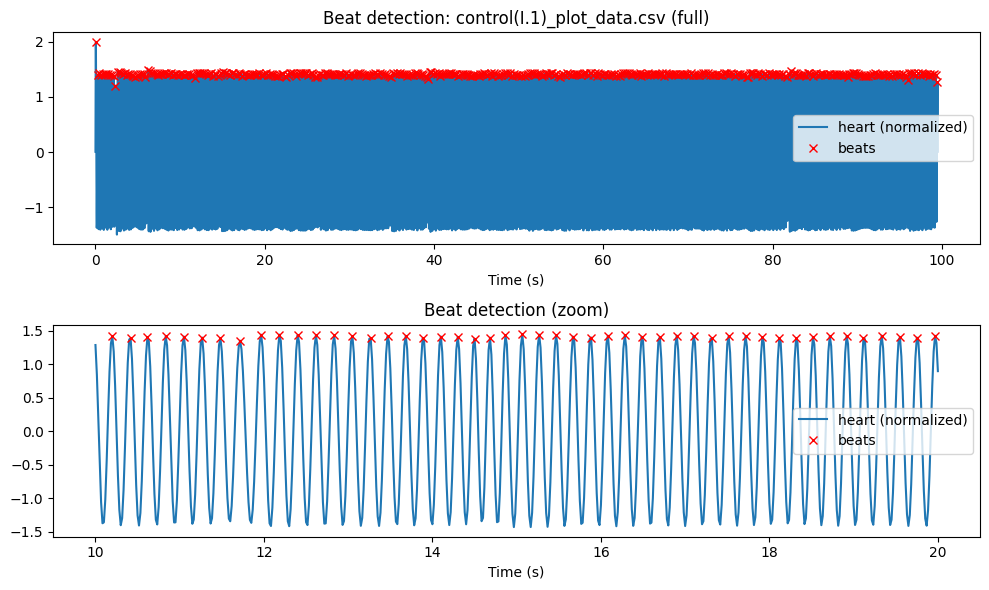

In [13]:
rec = records[0]
heart = extract_heart_for_beats(rec.signal, rec.fs)
peaks, heart_norm = detect_beats(heart, rec.fs)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
axes[0].plot(rec.time_s, heart_norm, label="heart (normalized)")
axes[0].plot(rec.time_s[peaks], heart_norm[peaks], "rx", label="beats")
axes[0].legend()
axes[0].set_title(f"Beat detection: {rec.path.name} (full)")
axes[0].set_xlabel("Time (s)")

mask = zoom_mask(rec.time_s)
start, end = zoom_window(rec.time_s)
peaks_zoom = peaks[(rec.time_s[peaks] >= start) & (rec.time_s[peaks] <= end)]
axes[1].plot(rec.time_s[mask], heart_norm[mask], label="heart (normalized)")
axes[1].plot(rec.time_s[peaks_zoom], heart_norm[peaks_zoom], "rx", label="beats")
axes[1].legend()
axes[1].set_title("Beat detection (zoom)")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
save_fig(f"beat_detection_{rec.path.stem}.png")
plt.show()


## 4b) Beat detection visualization by category

These plots show envelope peaks for one file per category.
Check for consistent peak spacing and absence of respiratory leakage.


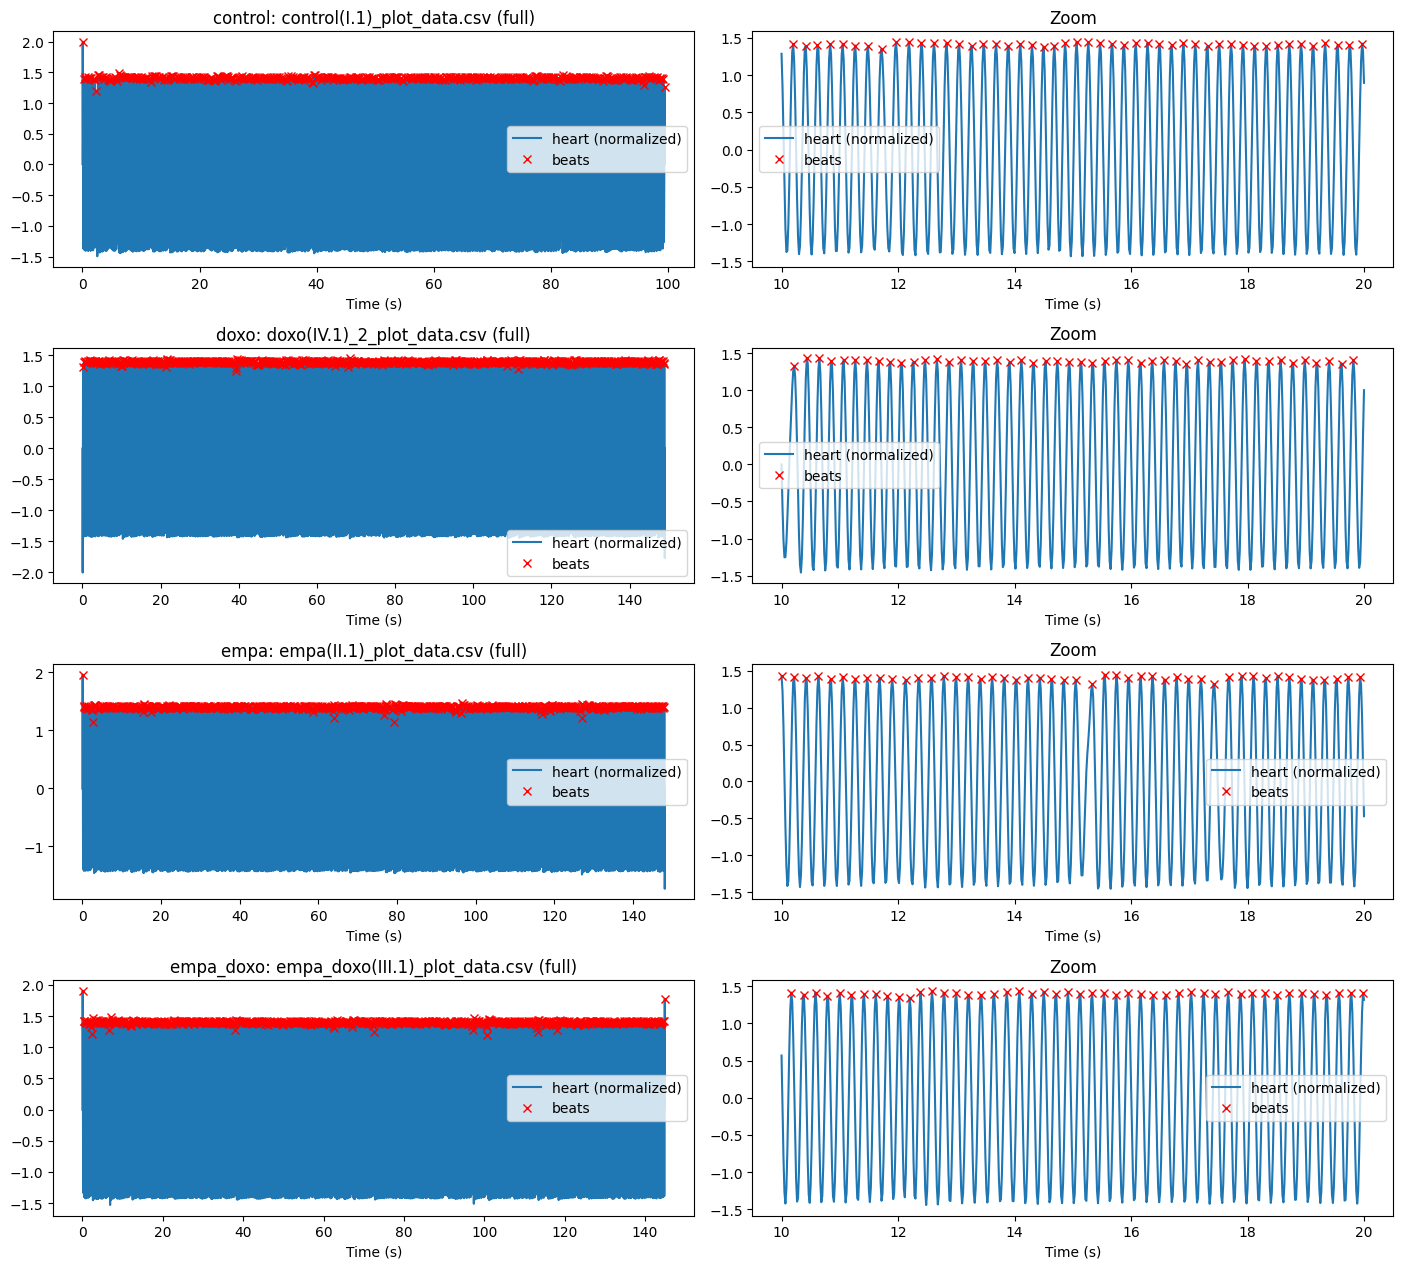

In [14]:
def plot_category_beats(records: list[Record], method: str) -> None:
    grouped: dict[str, list[Record]] = {}
    for rec in records:
        grouped.setdefault(rec.label, []).append(rec)

    labels = sorted(grouped.keys())
    fig, axes = plt.subplots(len(labels), 2, figsize=(14, 3.2 * len(labels)))
    if len(labels) == 1:
        axes = [axes]

    for row, label in enumerate(labels):
        rec = grouped[label][0]
        heart = extract_heart_for_beats(rec.signal, rec.fs)
        peaks, heart_norm = detect_beats(heart, rec.fs)
        full_ax = axes[row][0]
        zoom_ax = axes[row][1]
        full_ax.plot(rec.time_s, heart_norm, label="heart (normalized)")
        full_ax.plot(rec.time_s[peaks], heart_norm[peaks], "rx", label="beats")
        full_ax.set_title(f"{label}: {rec.path.name} (full)")
        full_ax.set_xlabel("Time (s)")
        full_ax.legend()

        mask = zoom_mask(rec.time_s)
        start, end = zoom_window(rec.time_s)
        peaks_zoom = peaks[(rec.time_s[peaks] >= start) & (rec.time_s[peaks] <= end)]
        zoom_ax.plot(rec.time_s[mask], heart_norm[mask], label="heart (normalized)")
        zoom_ax.plot(rec.time_s[peaks_zoom], heart_norm[peaks_zoom], "rx", label="beats")
        zoom_ax.set_title("Zoom")
        zoom_ax.set_xlabel("Time (s)")
        zoom_ax.legend()

    plt.tight_layout()
    save_fig(f"beat_detection_by_category_{method}.png")
    plt.show()


plot_category_beats(records, SEPARATION_METHOD)


## 4c) HR estimate from detected beats
Cross-check BPM from envelope peaks (median inter-beat interval).


In [15]:
def estimate_hr_peaks(signal: np.ndarray, fs: float) -> float | None:
    heart = extract_heart_for_beats(signal, fs)
    peaks, _ = detect_beats(heart, fs)
    if len(peaks) < 2:
        return None
    intervals = np.diff(peaks) / fs
    return 60.0 / float(np.median(intervals))


hr_peaks = []
for rec in records:
    hr = estimate_hr_peaks(rec.signal, rec.fs)
    hr_peaks.append(hr)

print("Peak HR (bpm):", [round(h, 1) if h else None for h in hr_peaks])
if any(h is not None for h in hr_peaks):
    arr = np.array([h for h in hr_peaks if h is not None])
    print(f"Peak HR summary: mean={arr.mean():.1f}, median={np.median(arr):.1f}, min={arr.min():.1f}, max={arr.max():.1f}")


Peak HR (bpm): [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
Peak HR summary: mean=300.0, median=300.0, min=300.0, max=300.0


## 5) Extract beat windows (fixed length)

Beat windows are resampled to a fixed length for feature extraction.
At 60 fps, windows contain very few raw samples, limiting shape fidelity.


In [16]:
def extract_beat_windows(
    signal: np.ndarray,
    peaks: np.ndarray,
    fs: float,
    window_s: tuple[float, float],
    resample_len: int,
) -> list[np.ndarray]:
    pre_s, post_s = window_s
    pre = int(pre_s * fs)
    post = int(post_s * fs)
    windows: list[np.ndarray] = []
    for peak in peaks:
        start = peak - pre
        end = peak + post
        if start < 0 or end >= len(signal):
            continue
        snippet = signal[start:end]
        x_old = np.linspace(0.0, 1.0, num=len(snippet), endpoint=False)
        x_new = np.linspace(0.0, 1.0, num=resample_len, endpoint=False)
        windows.append(np.interp(x_new, x_old, snippet))
    return windows


beat_windows = extract_beat_windows(heart, peaks, rec.fs, BEAT_WINDOW_S, RESAMPLE_LEN)
len(beat_windows)


479

## Ground-truth groups (from filenames)

Labels are derived from filename prefixes only and are used **only** for evaluation. Clustering models do not see these labels during fitting. The four target groups are:

- control
- doxo (including doxo_re)
- empa
- empa_doxo (including preconditionare_empa_doxo)



## 6) Build dataset (beats -> features -> grouping)

We build beat-level samples and labels for evaluation only.
Clustering is unsupervised; labels are used strictly for post-hoc metrics.


In [17]:
beats: list[np.ndarray] = []
labels: list[str] = []
record_ids: list[str] = []

rng = np.random.default_rng(BEAT_SAMPLE_SEED)

for rec in records:
    heart = extract_heart_for_beats(rec.signal, rec.fs)
    peaks, _ = detect_beats(heart, rec.fs)
    windows = extract_beat_windows(heart, peaks, rec.fs, BEAT_WINDOW_S, RESAMPLE_LEN)
    if MAX_BEATS_PER_RECORD and len(windows) > MAX_BEATS_PER_RECORD:
        idx = rng.choice(len(windows), size=MAX_BEATS_PER_RECORD, replace=False)
        windows = [windows[i] for i in idx]
    beats.extend(windows)
    labels.extend([rec.label] * len(windows))
    record_ids.extend([rec.group_id] * len(windows))

X = np.stack(beats) if beats else np.empty((0, RESAMPLE_LEN))
y = np.array(labels)
record_ids = np.array(record_ids)
X.shape


(1080, 256)

## 7) MiniROCKET baseline (supervised)

This is a supervised baseline to gauge separability. It is not used for clustering.
Low accuracy suggests limited signal at beat level.


In [18]:
if MiniRocket is None or len(X) == 0:
    print("MiniRocket not available or no beats extracted.")
else:
    X3d = X[:, np.newaxis, :]
    rocket = MiniRocket()
    X_feat = rocket.fit_transform(X3d)
    if hasattr(X_feat, "to_numpy"):
        X_feat = X_feat.to_numpy()
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7))
    unique_groups = np.unique(record_ids)
    if len(unique_groups) >= 3:
        splits = GroupKFold(n_splits=min(5, len(unique_groups))).split(X_feat, y, record_ids)
        scores = cross_val_score(clf, X_feat, y, cv=splits)
        print(f"Group CV accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")
    else:
        clf.fit(X_feat, y)
        print("Trained on full data (insufficient groups for CV).")


Group CV accuracy: 0.226 +/- 0.121


## 8) Clustering options (exploratory)

Clustering uses beat-level features without labels; metrics are computed after fitting.
At 60 fps, expect weak separation because beats are under-sampled.


In [19]:
def z_normalize_beats(x: np.ndarray) -> np.ndarray:
    median = np.median(x, axis=1, keepdims=True)
    mad = np.median(np.abs(x - median), axis=1, keepdims=True) + 1e-9
    return (x - median) / mad


def evaluate_clustering(y_true: np.ndarray, y_pred: np.ndarray, label: str) -> dict:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if len(y_true) == 0 or len(np.unique(y_pred)) < 2:
        print(f"{label}: insufficient clusters for evaluation.")
        return {}

    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    true_labels = sorted(set(y_true))
    pred_labels = sorted(set(y_pred))
    true_map = {lab: idx for idx, lab in enumerate(true_labels)}
    pred_map = {lab: idx for idx, lab in enumerate(pred_labels)}
    contingency = np.zeros((len(true_labels), len(pred_labels)), dtype=int)
    for t, p in zip(y_true, y_pred):
        contingency[true_map[t], pred_map[p]] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency)
    matched = contingency[row_ind, col_ind].sum()
    best_acc = matched / len(y_true)
    mapping = {pred_labels[c]: true_labels[r] for r, c in zip(row_ind, col_ind)}

    print(f"{label} ARI: {ari:.3f} | NMI: {nmi:.3f} | purity: {best_acc:.3f}")
    print(f"{label} mapping (cluster -> label): {mapping}")
    print(pd.crosstab(pd.Series(y_pred, name="cluster"), pd.Series(y_true, name="label")))
    return {"clusters": y_pred, "mapping": mapping, "purity": best_acc}


if len(X) == 0:
    print("No beats extracted for clustering.")
else:
    X_norm = z_normalize_beats(X)
    pca = PCA(n_components=min(10, X_norm.shape[1]))
    X_pca = pca.fit_transform(X_norm)

    kmeans = KMeans(n_clusters=4, n_init=50, random_state=0)
    beat_clusters = kmeans.fit_predict(X_pca)
    evaluate_clustering(y, beat_clusters, label="Beat KMeans (PCA)")

    if MiniRocket is not None:
        X3d = X_norm[:, np.newaxis, :]
        rocket = MiniRocket()
        X_feat = rocket.fit_transform(X3d)
        if hasattr(X_feat, "to_numpy"):
            X_feat = X_feat.to_numpy()
        rocket_clusters = kmeans.fit_predict(X_feat)
        evaluate_clustering(y, rocket_clusters, label="Beat KMeans (MiniROCKET)")


Beat KMeans (PCA) ARI: 0.002 | NMI: 0.006 | purity: 0.304
Beat KMeans (PCA) mapping (cluster -> label): {3: 'control', 0: 'doxo', 2: 'empa', 1: 'empa_doxo'}
label    control  doxo  empa  empa_doxo
cluster                                
0             68   115    75        122
1             84   101    57        124
2              0     0     1          0
3             88    84    47        114


Beat KMeans (MiniROCKET) ARI: -0.001 | NMI: 0.003 | purity: 0.290
Beat KMeans (MiniROCKET) mapping (cluster -> label): {0: 'control', 1: 'doxo', 2: 'empa', 3: 'empa_doxo'}
label    control  doxo  empa  empa_doxo
cluster                                
0             59    57    32         71
1             79   105    66        119
2             16    26    22         43
3             86   112    60        127


## 8c) Beat-sequence clustering (5–10 beats per segment)

We split each recording into non-overlapping segments of N beats (N=5 or 10), cluster those segments, then evaluate how often segments map back to their source labels.


In [20]:
def build_beat_segments(windows: list[np.ndarray], beats_per_segment: int, stride: int | None = None) -> list[np.ndarray]:
    if beats_per_segment <= 0:
        return []
    if stride is None:
        stride = beats_per_segment
    segments = []
    for start in range(0, len(windows) - beats_per_segment + 1, stride):
        chunk = windows[start:start + beats_per_segment]
        segments.append(np.concatenate(chunk))
    return segments

def per_category_accuracy(y_true: np.ndarray, y_pred: np.ndarray, mapping: dict) -> tuple[float, dict]:
    mapped = np.array([mapping.get(p, None) for p in y_pred])
    overall = float(np.mean(mapped == y_true)) if len(y_true) else 0.0
    per_cat = {}
    for lab in sorted(set(y_true)):
        mask = y_true == lab
        correct = int(np.sum(mapped[mask] == lab))
        total = int(np.sum(mask))
        per_cat[lab] = {"correct": correct, "total": total, "acc": (correct / total) if total else 0.0}
    return overall, per_cat

for beats_per_segment in BEATS_PER_SEGMENTS:
    segments: list[np.ndarray] = []
    seg_labels: list[str] = []
    for rec in records:
        heart = extract_heart_for_beats(rec.signal, rec.fs)
        peaks = detect_beats_for_segments(heart, rec.fs)
        windows = extract_beat_windows(heart, peaks, rec.fs, BEAT_WINDOW_S, RESAMPLE_LEN)
        segs = build_beat_segments(windows, beats_per_segment, SEGMENT_STRIDE)
        segments.extend(segs)
        seg_labels.extend([rec.label] * len(segs))

    X_seg = np.stack(segments) if segments else np.empty((0, beats_per_segment * RESAMPLE_LEN))
    y_seg = np.array(seg_labels)

    print(f"\nSegment size: {beats_per_segment} beats")
    print(f"Total segments: {len(y_seg)}")
    if len(X_seg) == 0:
        print("No segments for clustering.")
        continue
    if len(X_seg) < 4:
        print(f"Not enough segments for 4 clusters (n={len(X_seg)}).")
        continue

    X_seg_norm = z_normalize_beats(X_seg)
    pca = PCA(n_components=min(10, X_seg_norm.shape[0], X_seg_norm.shape[1]))
    X_seg_pca = pca.fit_transform(X_seg_norm)

    kmeans = KMeans(n_clusters=4, n_init=50, random_state=0)
    seg_clusters = kmeans.fit_predict(X_seg_pca)
    result = evaluate_clustering(y_seg, seg_clusters, label=f"Beat-seq KMeans (N={beats_per_segment})")

    if result:
        overall, per_cat = per_category_accuracy(y_seg, seg_clusters, result["mapping"])
        print(f"Overall accuracy (mapped): {overall:.3f}")
        for lab, stats in per_cat.items():
            print(f"  {lab}: {stats['correct']}/{stats['total']} = {stats['acc']:.3f}")



Segment size: 5 beats
Total segments: 10912


Beat-seq KMeans (N=5) ARI: 0.002 | NMI: 0.002 | purity: 0.280
Beat-seq KMeans (N=5) mapping (cluster -> label): {2: 'control', 0: 'doxo', 3: 'empa', 1: 'empa_doxo'}
label    control  doxo  empa  empa_doxo
cluster                                
0            476   778   558        777
1            917  1050   728       1343
2            579   740   460        854
3            301   497   353        501
Overall accuracy (mapped): 0.280
  control: 579/2273 = 0.255
  doxo: 778/3065 = 0.254
  empa: 353/2099 = 0.168
  empa_doxo: 1343/3475 = 0.386



Segment size: 10 beats
Total segments: 10822


Beat-seq KMeans (N=10) ARI: 0.003 | NMI: 0.003 | purity: 0.277
Beat-seq KMeans (N=10) mapping (cluster -> label): {2: 'control', 0: 'doxo', 3: 'empa', 1: 'empa_doxo'}
label    control  doxo  empa  empa_doxo
cluster                                
0            462   751   540        743
1            796   880   592       1164
2            620   809   492        935
3            375   600   460        603
Overall accuracy (mapped): 0.277
  control: 620/2253 = 0.275
  doxo: 751/3040 = 0.247
  empa: 460/2084 = 0.221
  empa_doxo: 1164/3445 = 0.338


## 8b) Beat-shape clustering with k-Shape

k-Shape clusters by waveform shape. This is unreliable at 60 fps due to low samples per beat.
Results are included for completeness but should not be over-interpreted.


In [21]:
# k-Shape clustering removed for clarity; 60 fps yields limited beat shape detail.


## 9) Visualize clustering results

Embedding plots compare ground truth vs clusters; overlap indicates weak separability.
Use these for qualitative inspection, not as evidence of causality.


/Users/taddeusbuica/Desktop/experiments/heart-ts-analysis/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


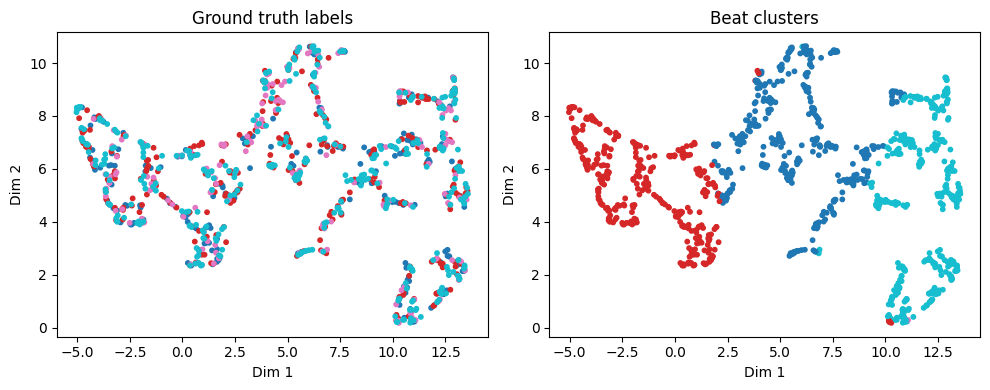

In [22]:
if len(X) == 0:
    print("No beats extracted for embedding.")
elif "beat_clusters" not in globals():
    print("Run clustering before embedding.")
else:
    X_norm = z_normalize_beats(X)
    if UMAP is not None:
        emb = UMAP(n_components=2, random_state=0).fit_transform(X_norm)
    else:
        emb = PCA(n_components=2).fit_transform(X_norm)

    label_to_id = {lab: idx for idx, lab in enumerate(sorted(set(y)))}
    y_ids = np.array([label_to_id[lab] for lab in y])

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(emb[:, 0], emb[:, 1], c=y_ids, cmap="tab10", s=10)
    axes[0].set_title("Ground truth labels")
    axes[1].scatter(emb[:, 0], emb[:, 1], c=beat_clusters, cmap="tab10", s=10)
    axes[1].set_title("Beat clusters")
    for ax in axes:
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
    plt.tight_layout()
    save_fig("embedding_labels_vs_clusters.png")
    plt.show()


## 10) Record-level clustering (no label leakage)

Aggregating beat features per recording can be more stable than beat-level clustering.
This is the preferred unsupervised target when sampling is low.


In [23]:
if MiniRocket is None or len(X) == 0:
    print("MiniRocket not available or no beats extracted.")
else:
    X3d = X[:, np.newaxis, :]
    if "X_feat" in globals():
        features = X_feat
    else:
        rocket = MiniRocket()
        features = rocket.fit_transform(X3d)
    if hasattr(features, "to_numpy"):
        features = features.to_numpy()

    record_features = []
    record_labels = []
    record_names = []
    for rec in records:
        idx = np.where(record_ids == rec.group_id)[0]
        if len(idx) == 0:
            continue
        record_features.append(features[idx].mean(axis=0))
        record_labels.append(rec.label)
        record_names.append(rec.group_id)

    record_features = np.vstack(record_features)
    record_labels = np.array(record_labels)

    kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
    record_clusters = kmeans.fit_predict(record_features)
    evaluate_clustering(record_labels, record_clusters, label="Record-level KMeans")


Record-level KMeans ARI: -0.041 | NMI: 0.195 | purity: 0.389
Record-level KMeans mapping (cluster -> label): {3: 'control', 1: 'doxo', 2: 'empa', 0: 'empa_doxo'}
label    control  doxo  empa  empa_doxo
cluster                                
0              0     2     1          3
1              1     0     0          0
2              0     1     1          1
3              3     2     1          2


## 10b) Record-level features (band power + PSD HR + HRV proxy)
This uses record-level features that remain meaningful at 60 fps.
It avoids beat-shape reliance and is preferred for clustering here.


In [24]:
def band_power(signal: np.ndarray, fs: float, band: tuple[float, float]) -> float:
    f, pxx = welch(signal, fs=fs, nperseg=min(2048, len(signal)))
    low, high = band
    mask = (f >= low) & (f <= high)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(pxx[mask], f[mask]))


record_features = []
record_labels = []

for rec in records:
    resp_band = resp_band_from_target()
    resp_power = band_power(rec.signal, rec.fs, resp_band)
    heart_power = band_power(rec.signal, rec.fs, HEART_BAND_HZ)
    hr_psd = estimate_hr_psd(rec.signal, rec.fs, HEART_BAND_HZ, SEPARATION_METHOD)

    heart = extract_heart_for_beats(rec.signal, rec.fs)
    peaks, _ = detect_beats(heart, rec.fs)
    if len(peaks) >= 3:
        intervals = np.diff(peaks) / rec.fs
        hrv_proxy = float(np.std(intervals))
    else:
        hrv_proxy = 0.0

    record_features.append([resp_power, heart_power, hr_psd or 0.0, hrv_proxy])
    record_labels.append(rec.label)

record_features = np.array(record_features)
record_labels = np.array(record_labels)

kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
rec_clusters = kmeans.fit_predict(record_features)
evaluate_clustering(record_labels, rec_clusters, label="Record features KMeans")


Record features KMeans ARI: 0.000 | NMI: 0.275 | purity: 0.444
Record features KMeans mapping (cluster -> label): {1: 'control', 0: 'doxo', 3: 'empa', 2: 'empa_doxo'}
label    control  doxo  empa  empa_doxo
cluster                                
0              1     3     1          3
1              2     2     0          2
2              1     0     0          1
3              0     0     2          0


{'clusters': array([1, 0, 1, 2, 1, 0, 0, 1, 0, 3, 0, 3, 1, 0, 0, 2, 1, 0], dtype=int32),
 'mapping': {1: 'control', 0: 'doxo', 3: 'empa', 2: 'empa_doxo'},
 'purity': 0.4444444444444444}

In [25]:
def log_cycle_counts(record_name: str, duration_s: float, resp_peaks: int, heart_peaks: int) -> None:
    """
    Logs validation metrics for detected cycles.
    """
    resp_rate_bpm = (resp_peaks / duration_s) * 60.0
    heart_rate_bpm = (heart_peaks / duration_s) * 60.0
    
    print(f"File: {record_name:<35} | Duration: {duration_s:>5.2f}s")
    print(f"  > Resp Cycles:  {resp_peaks:>3} (Rate: {resp_rate_bpm:>5.1f} cycles/min) [Target: 70-80]")
    print(f"  > Heart Beats:  {heart_peaks:>3} (Rate: {heart_rate_bpm:>5.1f} beats/min)  [Target: 270-310]")
    print("-" * 80)


print("\n--- VALIDATION LOGS ---\n")
for rec in records:
    # 1. Separate components
    resp, heart = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
    
    # 2. Detect peaks
    # Resp peaks
    resp_metrics = analyze_resp_cycles(resp, rec.fs)
    n_resp_cycles = len(resp_metrics['peaks'])
    
    # Heart peaks
    heart_peaks, _ = detect_beats(heart, rec.fs)
    n_heart_beats = len(heart_peaks)
    
    # 3. Log results
    duration = len(rec.signal) / rec.fs
    log_cycle_counts(rec.path.name, duration, n_resp_cycles, n_heart_beats)

def validate_rates(records: list[Record]) -> None:
    print("\n--- AUTOMATED RANGE CHECKS ---\n")
    print(f"{'File':<35} | {'Resp (70-80 cpm)':<15} | {'Heart (270-310)':<17} | {'Amp (resp/heart)':<17} | {'Status'}")
    print("-" * 80)
    
    for rec in records:
        resp, heart = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
        
        # Get rates
        resp_metrics = analyze_resp_cycles(resp, rec.fs)
        n_resp = len(resp_metrics['peaks'])
        duration = len(rec.signal) / rec.fs
        resp_bpm = (n_resp / duration) * 60.0
        
        heart_peaks, _ = detect_beats(heart, rec.fs)
        n_heart = len(heart_peaks)
        heart_bpm = (n_heart / duration) * 60.0
        
        # Check ranges (strict expected bands)
        resp_ok = 70.0 <= resp_bpm <= 80.0
        heart_ok = 270.0 <= heart_bpm <= 310.0
        
        signal = preprocess_signal(rec.signal)
        resp_lp = sosfiltfilt(lowpass_sos(RESP_DECOMP_CUTOFF_HZ, rec.fs), signal)
        heart_bp = sosfiltfilt(butter_sos(HEART_DECOMP_BAND_HZ, rec.fs), signal)

        resp_amp = float(np.ptp(resp_lp))
        heart_amp = float(np.ptp(heart_bp))
        amp_ratio = resp_amp / (heart_amp + 1e-9)
        amp_ok = amp_ratio >= 1.0

        status = "PASS" if (resp_ok and heart_ok and amp_ok) else "CHECK"
        
        print(f"{rec.path.name:<35} | {resp_bpm:>5.1f} cpm {'OK' if resp_ok else 'X':<3}      | {heart_bpm:>5.1f} bpm {'OK' if heart_ok else 'X':<3}        | {amp_ratio:>6.2f} {'OK' if amp_ok else 'X':<3}       | {status}")

validate_rates(records)



--- VALIDATION LOGS ---

File: control(I.1)_plot_data.csv          | Duration: 99.55s
  > Resp Cycles:  120 (Rate:  72.3 cycles/min) [Target: 70-80]
  > Heart Beats:  493 (Rate: 297.1 beats/min)  [Target: 270-310]
--------------------------------------------------------------------------------
File: control(I.2)_plot_data.csv          | Duration: 166.65s
  > Resp Cycles:  201 (Rate:  72.4 cycles/min) [Target: 70-80]
  > Heart Beats:  837 (Rate: 301.4 beats/min)  [Target: 270-310]
--------------------------------------------------------------------------------
File: control(I.3)_plot_data.csv          | Duration: 104.95s
  > Resp Cycles:  126 (Rate:  72.0 cycles/min) [Target: 70-80]
  > Heart Beats:  528 (Rate: 301.9 beats/min)  [Target: 270-310]
--------------------------------------------------------------------------------
File: control(I.4)_plot_data.csv          | Duration: 105.42s
  > Resp Cycles:  127 (Rate:  72.3 cycles/min) [Target: 70-80]
  > Heart Beats:  531 (Rate: 302.2 be

File: preconditionare_empa_doxo(V.2)_plot_data.csv | Duration: 97.45s
  > Resp Cycles:  118 (Rate:  72.7 cycles/min) [Target: 70-80]
  > Heart Beats:  494 (Rate: 304.2 beats/min)  [Target: 270-310]
--------------------------------------------------------------------------------
File: preconditionare_empa_doxo(V.3)_plot_data.csv | Duration: 96.23s
  > Resp Cycles:  116 (Rate:  72.3 cycles/min) [Target: 70-80]
  > Heart Beats:  482 (Rate: 300.5 beats/min)  [Target: 270-310]
--------------------------------------------------------------------------------

--- AUTOMATED RANGE CHECKS ---

File                                | Resp (70-80 cpm) | Heart (270-310)   | Amp (resp/heart)  | Status
--------------------------------------------------------------------------------


control(I.1)_plot_data.csv          |  72.3 cpm OK       | 297.1 bpm OK         |   1.68 OK        | PASS
control(I.2)_plot_data.csv          |  72.4 cpm OK       | 301.4 bpm OK         |   2.37 OK        | PASS
control(I.3)_plot_data.csv          |  72.0 cpm OK       | 301.9 bpm OK         |   1.68 OK        | PASS
control(I.4)_plot_data.csv          |  72.3 cpm OK       | 302.2 bpm OK         |   1.24 OK        | PASS
doxo(IV.1)_2_plot_data.csv          |  72.0 cpm OK       | 295.8 bpm OK         |   1.53 OK        | PASS
doxo(IV.1)_plot_data.csv            |  72.3 cpm OK       | 299.0 bpm OK         |   1.77 OK        | PASS
doxo(IV.2)_plot_data.csv            |  72.2 cpm OK       | 298.4 bpm OK         |   1.07 OK        | PASS
doxo_re(IV.3)_plot_data.csv         |  71.9 cpm OK       | 301.8 bpm OK         |   2.65 OK        | PASS
doxo_re(IV.4)_plot_data.csv         |  72.4 cpm OK       | 303.6 bpm OK         |   1.92 OK        | PASS
empa(II.1)_plot_data.csv            |  71.7 cp

empa_doxo(III.3)_plot_data.csv      |  71.8 cpm OK       | 300.3 bpm OK         |   2.05 OK        | PASS
preconditionare_empa_doxo(V.1)_plot_data.csv |  72.2 cpm OK       | 303.7 bpm OK         |   2.52 OK        | PASS


preconditionare_empa_doxo(V.2)_plot_data.csv |  72.7 cpm OK       | 304.2 bpm OK         |   1.66 OK        | PASS
preconditionare_empa_doxo(V.3)_plot_data.csv |  72.3 cpm OK       | 300.5 bpm OK         |   2.74 OK        | PASS


In [26]:
def record_fig_dir(rec: Record) -> Path:
    return FIG_DIR / "by_record" / rec.path.stem


def plot_record_psd(rec: Record, out_dir: Path) -> None:
    f, pxx = welch(rec.signal, fs=rec.fs, nperseg=min(2048, len(rec.signal)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.semilogy(f, pxx)
    ax.set_title(f"PSD: {rec.path.name}")
    ax.set_xlabel("Hz")
    ax.set_ylabel("Power")
    ax.set_xlim(0, 20)
    plt.tight_layout()
    save_fig(f"psd_{rec.path.stem}.png", out_dir=out_dir)
    plt.close(fig)


def plot_record_fft_decomposition(rec: Record, out_dir: Path) -> None:
    resp_fft, heart_fft = decompose_for_plot(rec.signal, rec.fs, method="fft")
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    axes[0].plot(rec.time_s, rec.signal, label="raw", alpha=0.5)
    axes[0].plot(rec.time_s, resp_fft, label="resp (fft)")
    axes[0].plot(rec.time_s, heart_fft, label="heart (fft band)")
    axes[0].legend()
    axes[0].set_title(f"FFT decomposition: {rec.path.name} (full)")
    axes[0].set_xlabel("Time (s)")

    mask = zoom_mask(rec.time_s)
    axes[1].plot(rec.time_s[mask], rec.signal[mask], label="raw", alpha=0.5)
    axes[1].plot(rec.time_s[mask], resp_fft[mask], label="resp (fft)")
    axes[1].plot(rec.time_s[mask], heart_fft[mask], label="heart (fft band)")
    axes[1].legend()
    axes[1].set_title("FFT decomposition (zoom)")
    axes[1].set_xlabel("Time (s)")

    plt.tight_layout()
    save_fig(f"fft_decomposition_{rec.path.stem}.png", out_dir=out_dir)
    plt.close(fig)


def plot_record_decomposition(rec: Record, method: str, output_tag: str, out_dir: Path) -> None:
    resp, heart = decompose_for_plot(rec.signal, rec.fs, method=method)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(rec.time_s, rec.signal, label="raw", alpha=0.4)
    axes[0].plot(rec.time_s, resp, label="resp")
    axes[0].plot(rec.time_s, heart, label="heart")
    axes[0].set_title(f"{rec.path.name} (full)")
    axes[0].set_xlabel("Time (s)")
    axes[0].legend()

    mask = zoom_mask(rec.time_s)
    axes[1].plot(rec.time_s[mask], rec.signal[mask], label="raw", alpha=0.4)
    axes[1].plot(rec.time_s[mask], resp[mask], label="resp")
    axes[1].plot(rec.time_s[mask], heart[mask], label="heart")
    axes[1].set_title("Zoom")
    axes[1].set_xlabel("Time (s)")
    axes[1].legend()

    plt.tight_layout()
    save_fig(f"decomposition_{rec.path.stem}_{output_tag}.png", out_dir=out_dir)
    plt.close(fig)


def plot_record_beats(rec: Record, method: str, out_dir: Path) -> None:
    heart = extract_heart_for_beats(rec.signal, rec.fs)
    peaks, heart_norm = detect_beats(heart, rec.fs)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(rec.time_s, heart_norm, label="heart (normalized)")
    axes[0].plot(rec.time_s[peaks], heart_norm[peaks], "rx", label="beats")
    axes[0].set_title(f"{rec.path.name} (full)")
    axes[0].set_xlabel("Time (s)")
    axes[0].legend()

    mask = zoom_mask(rec.time_s)
    start, end = zoom_window(rec.time_s)
    peaks_zoom = peaks[(rec.time_s[peaks] >= start) & (rec.time_s[peaks] <= end)]
    axes[1].plot(rec.time_s[mask], heart_norm[mask], label="heart (normalized)")
    axes[1].plot(rec.time_s[peaks_zoom], heart_norm[peaks_zoom], "rx", label="beats")
    axes[1].set_title("Zoom")
    axes[1].set_xlabel("Time (s)")
    axes[1].legend()

    plt.tight_layout()
    save_fig(f"beat_detection_{rec.path.stem}_{method}.png", out_dir=out_dir)
    plt.close(fig)


def plot_record_resp_cycles(rec: Record, output_tag: str, out_dir: Path) -> None:
    resp_full = extract_resp_for_cycles(rec.signal, rec.fs)
    trim = int(RESP_PLOT_TRIM_S * rec.fs)
    if trim * 2 < len(resp_full):
        resp = resp_full[trim:-trim]
        time_s = rec.time_s[trim:-trim]
    else:
        resp = resp_full
        time_s = rec.time_s
    metrics = analyze_resp_cycles(resp, rec.fs)
    resp_smoothed = metrics["resp_smoothed"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(time_s, resp_smoothed, label="resp (smoothed)")
    axes[0].plot(time_s[metrics["peaks"]], resp_smoothed[metrics["peaks"]], "g^", label="peaks")
    axes[0].plot(time_s[metrics["troughs"]], resp_smoothed[metrics["troughs"]], "rv", label="troughs")
    axes[0].set_title(f"{rec.path.name} (full)")
    axes[0].set_xlabel("Time (s)")
    axes[0].legend()

    mask = zoom_mask(time_s)
    start, end = zoom_window(time_s)
    peaks_zoom = metrics["peaks"][(time_s[metrics["peaks"]] >= start) & (time_s[metrics["peaks"]] <= end)]
    troughs_zoom = metrics["troughs"][(time_s[metrics["troughs"]] >= start) & (time_s[metrics["troughs"]] <= end)]
    axes[1].plot(time_s[mask], resp_smoothed[mask], label="resp (smoothed)")
    axes[1].plot(time_s[peaks_zoom], resp_smoothed[peaks_zoom], "g^", label="peaks")
    axes[1].plot(time_s[troughs_zoom], resp_smoothed[troughs_zoom], "rv", label="troughs")
    axes[1].set_title("Zoom")
    axes[1].set_xlabel("Time (s)")
    axes[1].legend()

    plt.tight_layout()
    save_fig(f"resp_cycles_{rec.path.stem}_{output_tag}.png", out_dir=out_dir)
    plt.close(fig)


def export_all_record_figures(records: list[Record]) -> None:
    for rec in records:
        out_dir = record_fig_dir(rec)
        plot_record_psd(rec, out_dir)
        plot_record_fft_decomposition(rec, out_dir)
        plot_record_decomposition(rec, DECOMPOSITION_METHOD, DECOMPOSITION_OUTPUT_TAG, out_dir)
        plot_record_beats(rec, SEPARATION_METHOD, out_dir)
        plot_record_resp_cycles(rec, RESP_CYCLES_OUTPUT_TAG, out_dir)


export_all_record_figures(records)
